In this notebook we will give the user a gentle introduction to `openretina` through a visualization example. No pre-requisites are needed to run this notebook, apart from having installed the package, either through:
```
pip install openretina
```

Or by cloning the git repository and running:
```
git clone git@github.com:open-retina/open-retina.git
cd open-retina
pip install -e .
```



# Imports and data setup

In [1]:
import os
import time
from pathlib import Path

import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm.auto import tqdm

from openretina.data_io.hoefling_2024.responses import filter_responses, make_final_responses
from openretina.data_io.hoefling_2024.stimuli import movies_from_pickle
from openretina.models.core_readout import CoreReadout
from openretina.utils.file_utils import get_local_file_path
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from openretina.utils.plotting import (
    BADEN_TYPE_BOUNDARIES,
    create_roi_animation,
    display_video,
    extract_baden_group,
    numpy_to_mp4_video,
    prepare_video_for_display,
    stitch_videos,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

In this example, we are going to visualize the stimuli and model predictions for a simple "Core + Readout" model trained on data from Hoefling et al., 2024: "A chromatic feature detector in the retina signals visual context changes".


First, specify the folder in which you would like the stimuli data to be downloaded to.

In [2]:
# DATA_FOLDER = Path("~/PhD_data/euler_data").expanduser()
DATA_FOLDER = Path("/Data/euler_data").expanduser()

In [3]:
movie_stimulus_path = get_local_file_path(
    "https://gin.g-node.org/teulerlab/open-retina/raw/master/stimuli/eulerlab/rgc_natstim_72x64_joint_normalized_2024-10-11.pkl",
    DATA_FOLDER,
)

movie_stimuli = movies_from_pickle(movie_stimulus_path)

Let's visualize the test movie, which we are going to use in our visualizations in the rest of the notebook.

In [4]:
numpy_to_mp4_video(movie_stimuli.test, fps=30)

# Loading a model

Now we are going to load a retina model that was trained on neural responses to this data. This is as easy as running:

In [5]:
model = CoreReadout.load_from_checkpoint(
    "https://gin.g-node.org/teulerlab/open-retina/raw/checkpoints/model_checkpoints/24-01-2025/hoefling_2024_base_high_res.ckpt"
)

# Visualizing model predictions

We will now visualize the responses that the model gives to the video data:

In [6]:
# First, put the stimuli in a torch tensor, which is what the model expects.
stim = torch.Tensor(movie_stimuli.test).to(model.device)

# Second, we need to select one of the many experimental sessions the model was trained on to visualize a response.
example_session = model.readout.sessions[0]  # Can pick any number as long as it is in range

with torch.no_grad():
    predicted_response = model.forward(stim.unsqueeze(0), data_key=example_session)
predicted_response_numpy = predicted_response.squeeze().cpu().numpy()

We can plot the predicted responses of an example neuron as follows:

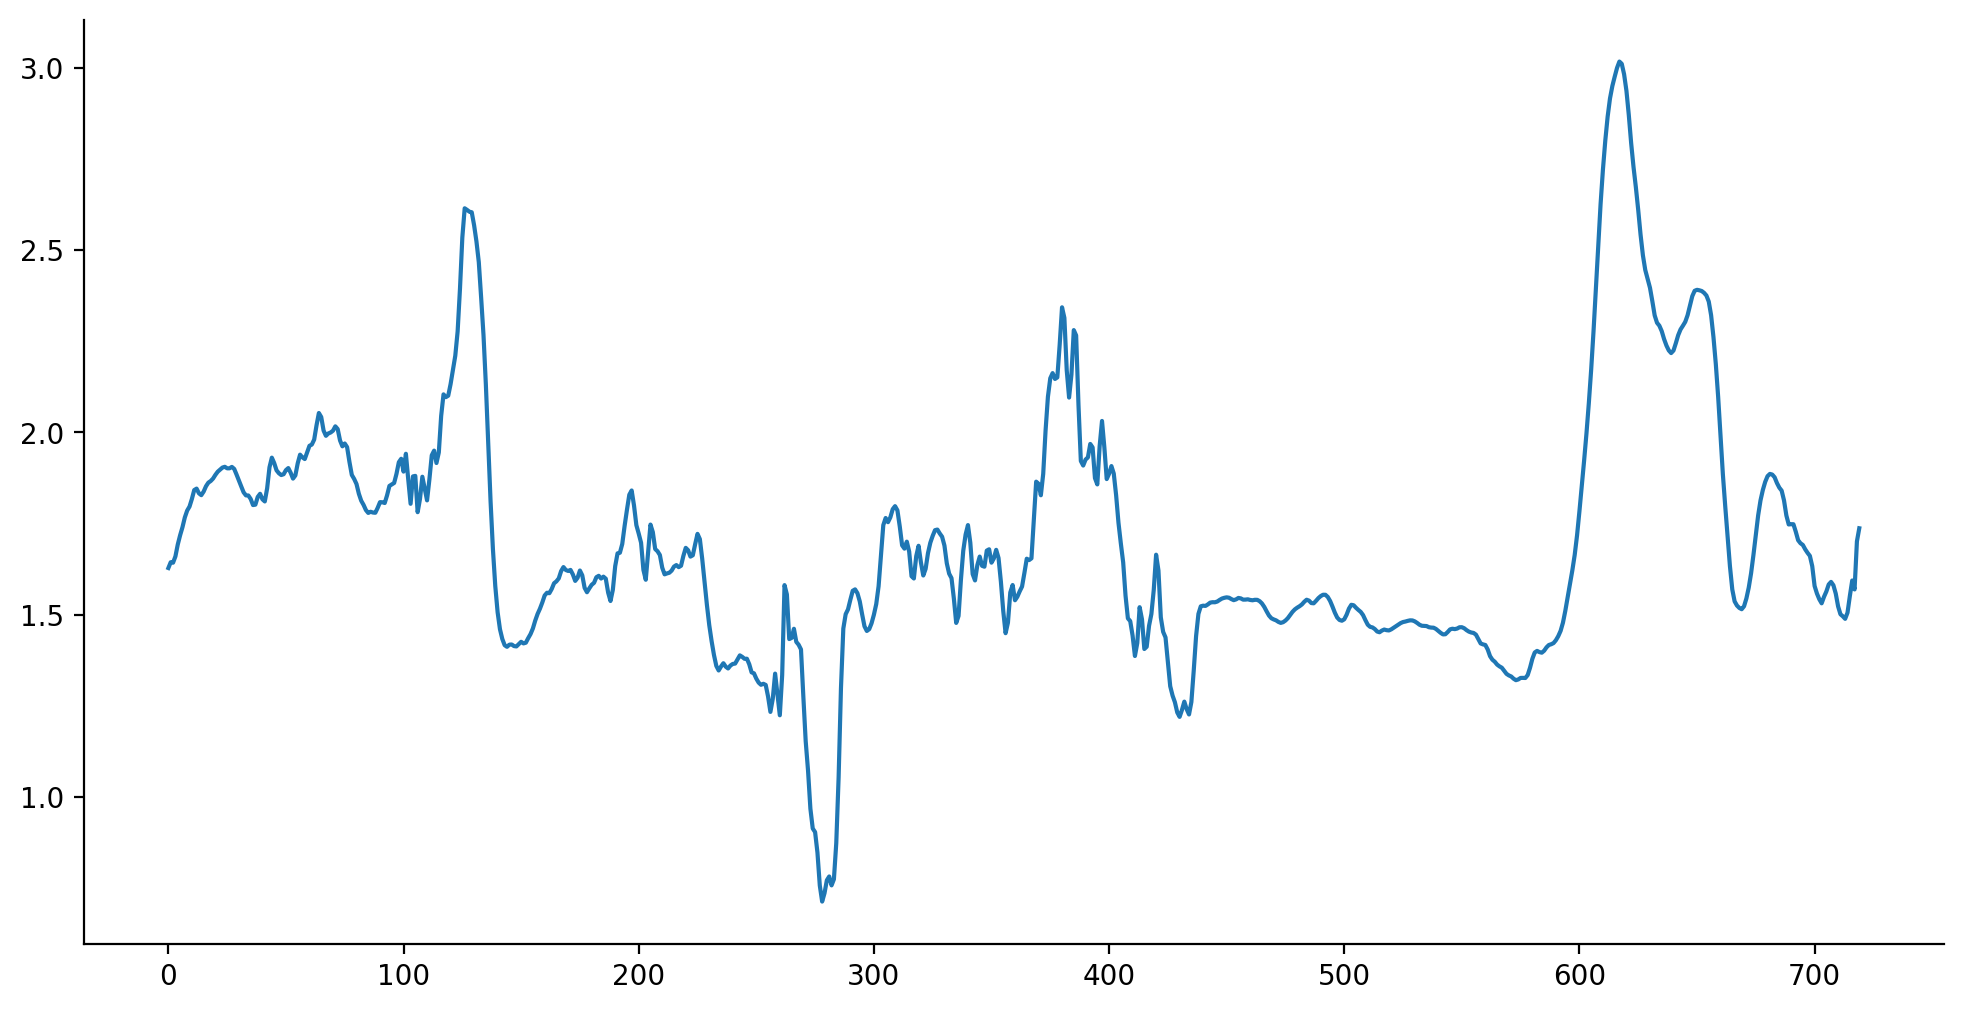

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(predicted_response_numpy[:, 0])
sns.despine()
plt.savefig("predicted_response.pdf")

But, to make things more interesting, we can also plot this from an "ROI view". In fact, the neural data used
to train the model came from 2P Calcium imaging, meaning we have access to the ROIs from which these neurons were recorded.

To extract the ROI mask, we access the `data_info` field within the model, which is a dictionary containing various kinds of information about the data that was used to train the model.

In [8]:
model.data_info.keys()

dict_keys(['n_neurons_dict', 'input_shape', 'sessions_kwargs', 'movie_norm_dict'])

In [9]:
# Let's see what extra information we have about the sessions.
pp.pprint(model.data_info["sessions_kwargs"])

{   'session_1_ventral1_20200226': {   'eye': 'left',
                                       'group_assignment': numpy.ndarray(shape=(80,)),
                                       'roi_ids': numpy.ndarray(shape=(80,)),
                                       'roi_mask': numpy.ndarray(shape=(64, 64)),
                                       'scan_sequence_idx': 18},
    'session_1_ventral1_20200528': {   'eye': 'left',
                                       'group_assignment': numpy.ndarray(shape=(42,)),
                                       'roi_ids': numpy.ndarray(shape=(42,)),
                                       'roi_mask': numpy.ndarray(shape=(64, 64)),
                                       'scan_sequence_idx': 4},
    'session_1_ventral1_20200707': {   'eye': 'left',
                                       'group_assignment': numpy.ndarray(shape=(74,)),
                                       'roi_ids': numpy.ndarray(shape=(74,)),
                                       'roi_mask':

In [10]:
# What we need is the roi_mask, and the roi_ids. Optionally we can pass also the cell type identity.

roi_mask = model.data_info["sessions_kwargs"][example_session]["roi_mask"]
roi_ids = model.data_info["sessions_kwargs"][example_session]["roi_ids"]
cell_types = model.data_info["sessions_kwargs"][example_session]["group_assignment"]

roi_animation = create_roi_animation(
    roi_mask=roi_mask, activity=predicted_response_numpy.T, roi_ids=roi_ids, max_activity=5, visualize_ids=True
)

Generating frames:   0%|          | 0/720 [00:00<?, ?it/s]

In [11]:
numpy_to_mp4_video(roi_animation, fps=30)

We can also pass cell type information to visualize the cells colour coded by their type:

In [13]:
video = create_roi_animation(
    roi_mask=roi_mask,
    activity=predicted_response_numpy.T,
    roi_ids=roi_ids,
    cell_types=cell_types,  # array of cell type IDs
    type_boundaries=BADEN_TYPE_BOUNDARIES,
    max_activity=5,
    visualize_ids=False,
)

Generating frames for ROI animation:   0%|          | 0/720 [00:00<?, ?it/s]

In [ ]:
numpy_to_mp4_video(video, fps=30)

# Play with model predictions

Now that we have gone through some basics, let's go through a perhaps more engaging example. 

We will take the ROI response view from above a step further, by:
1. Showing the stimulus and the response side by side.
2. Add the ability to visualize different "broad" cell types as defined in [Baden et al., 2016](https://www.nature.com/articles/nature16468) (Slow On, Fast On, Off, On-Off, uncertain RGCs, ACs).

In [16]:
# Here we define some utilies to make the visualization easier.

videos_cache_folder = Path("./videos_cache").resolve()
videos_cache_folder.mkdir(exist_ok=True)

baden_groups = np.array([extract_baden_group(cell_type) for cell_type in cell_types])
baden_unique_groups = np.unique(baden_groups)

The first time a new type group is selected for display, the video will compute, which might take around 30s. After the first display, it should be shown again much faster.

In [17]:
import ipywidgets as widgets
import numpy as np
from IPython.display import clear_output, display

box_layout = widgets.Layout(
    display="flex",
    flex_flow="column",
    border="solid",
    width="100%",
    align_items="center",
    justify_content="center",
)
style = {"description_width": "initial"}

video_dict = {
    group: mask for group, mask in zip(baden_unique_groups, [baden_groups == group for group in baden_unique_groups])
}

video_dict["All cell types"] = np.ones_like(baden_groups).astype(bool)

video_dropdown = widgets.Dropdown(
    options=list(video_dict.keys()),
    value="All cell types",
    description="Select Video: ",
    layout=widgets.Layout(width="100%", max_width="600px", min_width="300px"),
    style=style,
)

video_output = widgets.Output()

loading = widgets.Label(value="🔄 Loading...", layout=widgets.Layout(visibility="hidden"))
empty = widgets.Label(value="")


def on_video_change(change):
    """Callback for dropdown selection change."""

    loading.layout.visibility = "visible"
    with video_output:
        clear_output(wait=True)
        if os.path.exists(os.path.join(videos_cache_folder, f"{change['new']}.mp4")):
            display_video(video_array=None, video_save_path=os.path.join(videos_cache_folder, f"{change['new']}.mp4"))
        else:
            group_mask = video_dict[change["new"]]
            stim_video = prepare_video_for_display(
                movie_stimuli.test[:, 30:, ...]
            )  # Skip the first 30 frames, to match response length
            response_video = create_roi_animation(
                roi_mask=roi_mask,
                activity=predicted_response_numpy.T[group_mask],
                roi_ids=roi_ids[group_mask],
                cell_types=cell_types[group_mask],  # array of cell type IDs
                type_boundaries=BADEN_TYPE_BOUNDARIES,  # boundaries between broad types
                max_activity=5,
                visualize_ids=False,
            )

            type_video = stitch_videos(stim_video, response_video)

            # Before displaying, clear video area of all previous content
            clear_output(wait=True)

            display_video(type_video, video_save_path=os.path.join(videos_cache_folder, f"{change['new']}.mp4"), fps=30)
            # loading.layout.visibility = "hidden"

    loading.layout.visibility = "hidden"


# Attach the callback to the dropdown
video_dropdown.observe(on_video_change, names="value")

# Display the widgets
display(widgets.VBox([video_dropdown, loading, video_output, empty], layout=box_layout))

# Initial video display
on_video_change({"new": video_dropdown.value, "old": None, "owner": video_dropdown, "type": "change"})

In [18]:
# Optionally, delete the video cache folder once you are done, to free up space.
# import shutil

# shutil.rmtree(videos_cache_folder)